In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
import random

In [2]:
#step1/7 设置随机数种子
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
     
setup_seed(2)
    
#step 2/7 划分训练集和测试集
data = np.loadtxt('./Data/News3.csv', delimiter=',', dtype=np.float32,skiprows = 1)

x=torch.from_numpy(data[:,1:-2]).cuda()
y=torch.from_numpy(data[:,[-1]]).cuda()

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=1)

In [3]:
#step 3/7 模型构建
class LR(nn.Module):
    #调用nn.Module模块构建LR模型
    def __init__(self):
        super(LR, self).__init__()
        self.linear1= nn.Linear(25,50)
        self.linear2= nn.Linear(50,4)
        self.linear3= nn.Linear(4,1)
        self.sigmoid= nn.Sigmoid()
        
    def forward(self,x):#确定函数模型
        x = self.sigmoid(self.linear1(x))
        x = self.sigmoid(self.linear2(x))
        x = self.sigmoid(self.linear3(x))
        return x


In [4]:
cudaMsg = torch.cuda.is_available()
lr_net=LR().cuda() #实例化模型并将其移至GPU

In [6]:
# step4/7 利用focal loss构造损失函数

class FocalLoss(nn.Module):
    def __init__(self,alpha=0.05,gamma=2):
        super(FocalLoss,self).__init__()
        self.alpha=alpha
        self.gamma=gamma
    def forward(self,y_pred,y_train):
        eps=1e-7
        loss_1=-1*self.alpha*torch.pow((1-y_pred),self.gamma)*torch.log(y_pred+eps)*y_train
        loss_0=-1*(1-self.alpha)*torch.pow(y_pred,self.gamma)*torch.log(1-y_pred+eps)*(1-y_train)
        loss=loss_0+loss_1
        return torch.mean(loss)
    

       
loss_fn=FocalLoss(alpha=0.04973157894736842)

loss_fn2 = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([0.06])).cuda()

# weights = torch.FloatTensor([9,1])
# criterion = nn.BCEWithLogitsLoss(pos_weight=weights).cuda()

0 0.02288990654051304
1 0.022879742085933685
2 0.022860461845993996
3 0.022833041846752167
4 0.022798409685492516
5 0.022757375612854958
6 0.022710701450705528
7 0.02265903726220131
8 0.02260301262140274
9 0.022543208673596382
10 0.022480158135294914
11 0.022414306178689003
12 0.022346043959259987
13 0.02227579429745674
14 0.022203898057341576
15 0.022130658850073814
16 0.022056305781006813
17 0.021981067955493927
18 0.021905165165662766
19 0.02182878367602825
20 0.021752141416072845
21 0.02167537994682789
22 0.021598640829324722
23 0.021522024646401405
24 0.02144564874470234
25 0.02136961556971073
26 0.02129400335252285
27 0.021218888461589813
28 0.021144330501556396
29 0.021070387214422226
30 0.020997118204832077
31 0.020924562588334084
32 0.020852750167250633
33 0.02078172378242016
34 0.020711500197649002
35 0.020642096176743507
36 0.020573534071445465
37 0.020505821332335472
38 0.020438970997929573
39 0.02037299983203411
40 0.02030791901051998
41 0.02024373784661293
42 0.0201804582

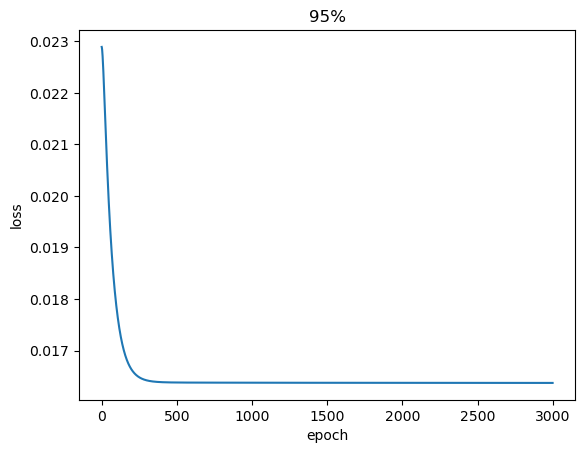

In [7]:
#step 5/7 选择优化器
lr_net=LR().cuda() #实例化模型并将其移至GPU
lr=0.01 #学习率
optimizer=torch.optim.SGD(lr_net.parameters(),lr=lr,momentum=0.9)

#step 6/7 模型训练
import torch.nn.functional as F
px,py=[],[]


for epoch in range(3000):
    y_pred=lr_net(x_train)
    loss=loss_fn(y_pred,y_train)
    print(epoch,loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    px.append(epoch)
    py.append(loss.item())
    
plt.plot(px,py)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('95%')
plt.show()


In [8]:

#step 7/7 测试及可视化展示

y_pred_test=lr_net(x_test)
loss_test=loss_fn(y_pred_test,y_test)


y_pred01=y_pred_test.tolist()
y_test01=y_test.tolist()
y_pred02=[]
y_test02=[]
for i in y_pred01:
    if i[0]<0.5:
        y_pred02.append(0)
    else:
        y_pred02.append(1)
for j in y_test01:
    if j[0]<0.5:
        y_test02.append(0)
    else:
        y_test02.append(1)


0.9476360489018717
0.19063545150501673
roc_auc: 0.4941662883123307 0.4941662883123307


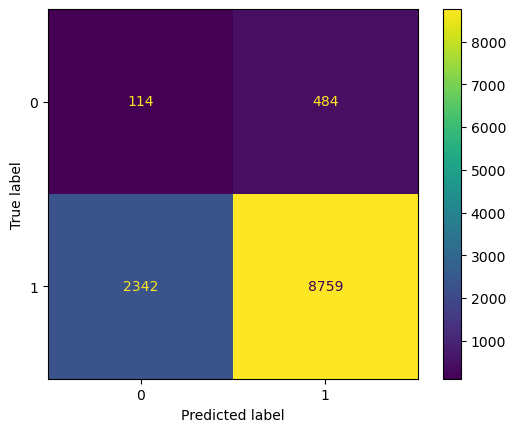

In [10]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import roc_auc_score

cm=confusion_matrix(y_test02,y_pred02)
cm_display=ConfusionMatrixDisplay(cm).plot()
print(precision_score(y_test02,y_pred02))
print(recall_score(y_test02, y_pred02, pos_label=0))


from sklearn.metrics import roc_curve,auc

y_pred_test = lr_net(x_test)
y_pred_proba = y_pred_test.detach().cpu().numpy()
auc_score = roc_auc_score(y_test02, y_pred_proba)

fpr, tpr, threshold = roc_curve(y_test02, y_pred_proba)

roc_auc = auc(fpr,tpr)   # 准确率代表所有正确的占所有数据的比值
print('roc_auc:', auc_score, roc_auc)


# lw = 2
# plt.subplot(1,1,1)
# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  # 假正率为横坐标，真正率为纵坐标做曲线
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('1 - specificity')
# plt.ylabel('Sensitivity')
# plt.title('ROC', y=0.5)
# plt.legend(loc="lower right")
# plt.show()

In [12]:
# 根据AUC值寻找最优alpha和gamma值的过程
from sklearn.metrics import roc_auc_score

best_auc = 0
best_alpha = 0
best_gamma = 0

alpha_values = np.linspace(0.0497,0.0498,20)
# gamma_values = np.linspace(0.1, 5, 10)

In [13]:
for alpha in alpha_values:
    gamma = 2
    print(f"{alpha}:Begin")
    lr_net=LR().cuda() #实例化模型
    loss_fn = FocalLoss(alpha=alpha, gamma=gamma).cuda()
    optimizer = torch.optim.SGD(lr_net.parameters(), lr=lr, momentum=0.9)

    for epoch in range(3000):
        y_pred = lr_net(x_train)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    y_pred_test = lr_net(x_test)
    y_pred_proba = y_pred_test.detach().cpu().numpy()
    auc_score = roc_auc_score(y_test02, y_pred_proba)

    if auc_score > best_auc:
        best_auc = auc_score
        best_alpha = alpha
        best_gamma = gamma

print("最优alpha值：", best_alpha)
print("最优gamma值：", best_gamma)
print("最优AUC值：", best_auc)

# 使用最优的alpha和gamma值重新训练模型
loss_fn = FocalLoss(alpha=best_alpha, gamma=best_gamma)
optimizer = torch.optim.SGD(lr_net.parameters(), lr=lr, momentum=0.9)

for epoch in range(300):
    y_pred = lr_net(x_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


0.0497:Begin


KeyboardInterrupt: 